In [10]:
# ce notebook fait une analyse du retard en fonction du temps pour des faibles retards 
import numpy as np 
import pandas as pd 
import scipy as sc 
import matplotlib.pyplot as plt 
from itertools import product
from sklearn import linear_model
from sklearn.utils import shuffle
import seaborn as sns

import missingno as msno

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import neighbors, metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn import kernel_ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import dummy

from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)

On annalyse ici différent modèles de regression linéaire et polynomiale avec ou sans régularisation en fonction des différentes variables prises en compte.

Trois étapes de temps sont à considérer : En premier lieu le retard prévisible longtemps à l'avance ( on base notre analyse sur le retard au départ )
Ensuite le retard prévisible quelques heures à l'avance ( on base notre analyse sur le retard au départ )
enfin le retard prévisible une fois que l'on connait l'heure de départ de l'avion ( on base notre analyse sur le retard à l'arrivé )

Tous nos modèles vont être testé via une validation croisée sur le jeux d'entrainement, un pré-choix des différents paramétres de régularisation sera effectué via une validation croisée par grille sur la base de la meilleure RMSE. Le choix final se faira sur la base de la meilleure RMSE  (on ne tient pas compte d'éventuelles restrictions de temps de calcul). Enfin, la performance du modèle final sera donnée en l'évaluant via le jeux de test. Le modèle final pourra ensuite être entrainé sur l'ensemble du jeux de donnée.

In [11]:
# ouvrir le dataset : 

data_fly = pd.read_csv('DF_CASCADE_DEST.csv')

On définie une fonction qui analyse via une cross-validation sur 5 folds les retards de regression linéaires simples non régularisées. 

In [3]:
# cette fonction retourne à la fois la rmse du modèle linéaire ou polynomiale (param n) (sans régularisation)
# et la rmse du classifieur naif.
def analyse(X_fit,y_fit,n):
    # ajouter des features polynomiales couplées 
    poly = PolynomialFeatures(n)
    X_fit = poly.fit_transform(X_fit)
    y_fit = y_fit  
    
    # on va standardiser les données de telle sorte à ce que 
    std_scale = preprocessing.StandardScaler().fit(X_fit)
    X_fit = std_scale.transform(X_fit)  
  
    
    # modèle de regression linéaire 
    reg = linear_model.LinearRegression()
    # évaluation de la rmse par validation croisée (sur 5 folds)
    y_predict_lr = cross_val_predict(reg,X_fit,y_fit,cv=5)
    rmse_mod = np.sqrt(metrics.mean_squared_error(y_fit, y_predict_lr[:,0]))
    print ("RMSE modèle : %.2f" % rmse_mod)
    # comparer à un classifieur naif 
    dum = dummy.DummyRegressor(strategy='mean')
    # Entraînement
    dum.fit(X_fit, y_fit)
    # Prédiction sur le jeu de test
    y_pred_dum = dum.predict(X_fit)
    # Evaluate
    rmse_naif = np.sqrt(metrics.mean_squared_error(y_fit, y_pred_dum[:,0]))
    print ("RMSE naive : %.2f" % rmse_naif)
    
    return (rmse_mod,rmse_naif)
    

On définie une fonction qui analyse le meilleur paramètre d'un modèle de regression ridge via une validation croisée de 5 folds sur une grille.

In [4]:
def best_model(X_fit,y_fit,n,params_min=10,params_max=12,nb_params=5):
    # ajouter des features polynomiales couplées 
    poly = PolynomialFeatures(n)
    X_fit = poly.fit_transform(X_fit)
    y_fit = y_fit   
    
    # on va standardiser les données de telle sorte à ce que 
    std_scale = preprocessing.StandardScaler().fit(X_fit)
    X_fit = std_scale.transform(X_fit)    
    
    # On crée un modèle de régression linéaire
    lr = linear_model.Ridge()
    # grille (échelle logarithmique)
    params = {'alpha': np.logspace(params_min,params_max,nb_params) }

    model_ridge_cv = GridSearchCV(lr,params,cv=5)
    model_ridge_cv.fit(X_fit,y_fit)
    # prédire les valeurs de y_test
    y_predict_lr = model_ridge_cv.predict(X_fit)
    print (X_fit.shape)
    print (params)
    print ('-------voici le meilleur paramètre---------')
    best_params = model_ridge_cv.best_params_
    print (best_params)
    # RSME  
    rmse_mod = np.sqrt(metrics.mean_squared_error(y_fit, y_predict_lr[:,0]))
    print ("RMSE du modèle : %.2f" % rmse_mod)
    # comparer avec rmse du classifieur naif 
    # comparer à un classifieur naif 
    dum = dummy.DummyRegressor(strategy='mean')
    # Entraînement
    dum.fit(X_fit, y_fit)
    # Prédiction sur le jeu de test
    y_pred_dum = dum.predict(X_fit)
    # Evaluate
    rmse_naif = np.sqrt(metrics.mean_squared_error(y_fit[:,0], y_pred_dum[:,0]))
    print ("RMSE naive : %.2f" % rmse_naif)
    
    return (rmse_mod,rmse_naif)


On définie une fonction qui (une fois choisie le meilleur paramètre) va évaluer la performance réelle sur le jeux de donnée test 

In [5]:
def perform(X_train,X_test,y_train,y_test,alpha,n=4):
    # ajouter des features polynomiales couplées 
    poly = PolynomialFeatures(n)
    X_fit = poly.fit_transform(X_train)
    y_fit = y_train
    X_test_n = poly.fit_transform(X_test)
    print (X_test_n.shape)
    
    # on va standardiser les données de telle sorte à ce que 
    std_scale = preprocessing.StandardScaler().fit(X_fit)
    
    X_fit = std_scale.transform(X_fit)
    X_test_n= std_scale.transform(X_test_n)
    
    # On crée un modèle de régression linéaire
    lr_model = linear_model.Ridge(alpha=alpha)
    
    # entrainer le modèle    
    lr_model.fit(X_fit,y_fit)
    # prédire les valeurs de X_test_n
    y_predict_lr = lr_model.predict(X_test_n)
    
    # RSME   
    rmse_mod = np.sqrt(metrics.mean_squared_error(y_test[:,0], y_predict_lr[:,0]))
    print ("RMSE du modèle : %.2f" % rmse_mod)
    # comparer avec rmse du classifieur naif 
    # comparer à un classifieur naif 
    dum = dummy.DummyRegressor(strategy='mean')
    # Entraînement
    dum.fit(X_fit, y_fit)
    # Prédiction sur le jeu de test
    y_pred_dum = dum.predict(X_test_n)
    # Evaluate
    rmse_naif = np.sqrt(metrics.mean_squared_error(y_test[:,0], y_pred_dum[:,0]))
    print ("RMSE naive : %.2f" % rmse_naif)
    
    return (rmse_mod,rmse_naif,y_predict_lr)
    

In [6]:
print (data_fly.columns[:])

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'CRS_DEP_TIME',
       'DEP_DELAY_NEW', 'ARR_DELAY_NEW', 'CANCELLED', 'DIVERTED',
       'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'TAIL_NUM', 'CRS_ARR_TIME',
       'DISTANCE', 'AIR_TIME', 'DAY', 'DAY_YEAR', 'MINUTES', 'MOY_WD_DAY',
       'TR_WD_DAY', 'MOY_ORIG', 'TR_ORIG', 'MOY_DEST', 'TR_DEST', 'MOY_TAIL',
       'TR_TAIL', 'LAT_DEP', 'LONG_DEP', 'LAT_ARR', 'LONG_ARR', 'HOURS_BEFORE',
       'MINUTES_ARR', 'CASCADE', 'CASCADE_DEST'],
      dtype='object')


In [7]:
# enlever la première colonne
data_fly = data_fly.drop(columns = ['Unnamed: 0'])

In [8]:
# analyser la dimmension du dataset
print (data_fly.shape)

(56641, 32)


In [9]:
# supprimer les valeurs inconnues
print (data_fly.shape)
data_fly = data_fly.dropna(0, subset=['DEP_DELAY_NEW'])
print (data_fly.shape)

(56641, 32)
(55942, 32)


In [10]:
# supprimer les valeurs inconnues
print (data_fly.shape)
data_fly = data_fly.dropna(0, subset=['CASCADE'])
print (data_fly.shape)

(55942, 32)
(55942, 32)


In [3]:
# on choisit de ne garder que les retards de moins de 200mins 
print (data_fly.shape[0])
data_fly = data_fly[data_fly['DEP_DELAY_NEW'] < 200]
print (data_fly.shape[0])

56641
55577


In [12]:
# mélanger les données : 
data_fly = shuffle(data_fly)

In [12]:
# choisir les variables qui nous interessent pour l'étude des correlations
data_fly_corr = data_fly[['DEP_DELAY_NEW', 'ARR_DELAY_NEW','DISTANCE', 'AIR_TIME', 'DAY', 'DAY_YEAR', 'MINUTES',
       'MOY_WD_DAY', 'TR_WD_DAY', 'MOY_ORIG', 'TR_ORIG', 'MOY_DEST', 'TR_DEST',
       'MOY_TAIL', 'TR_TAIL', 'HOURS_BEFORE', 'CASCADE','CASCADE_DEST']]

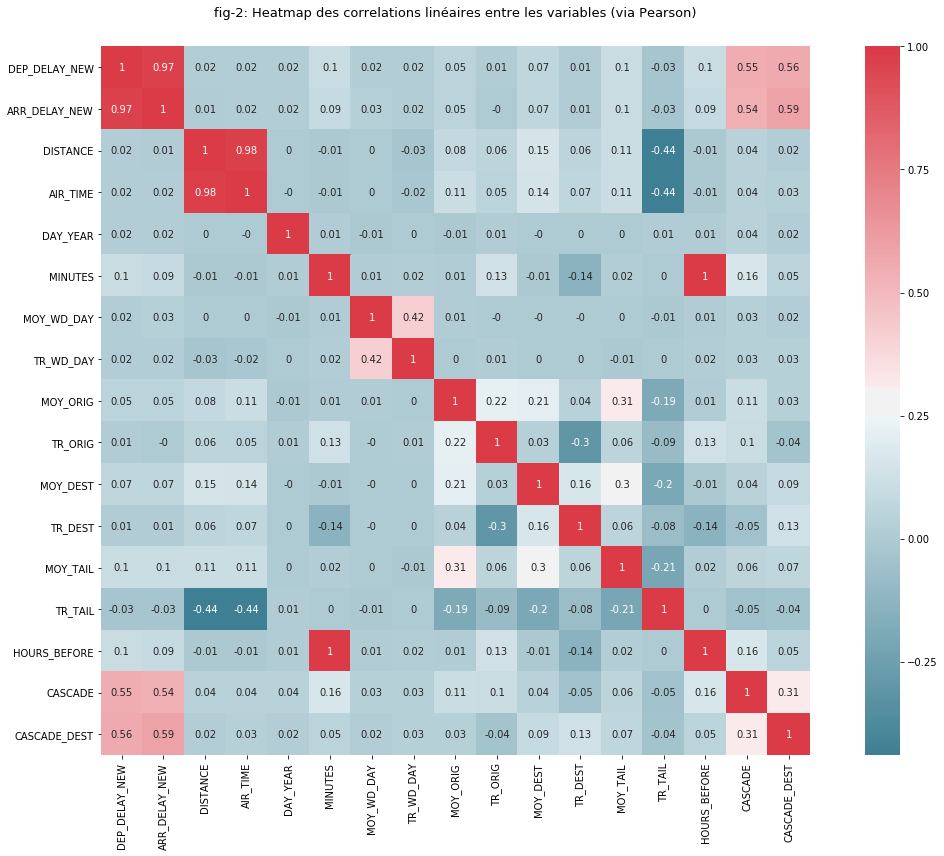

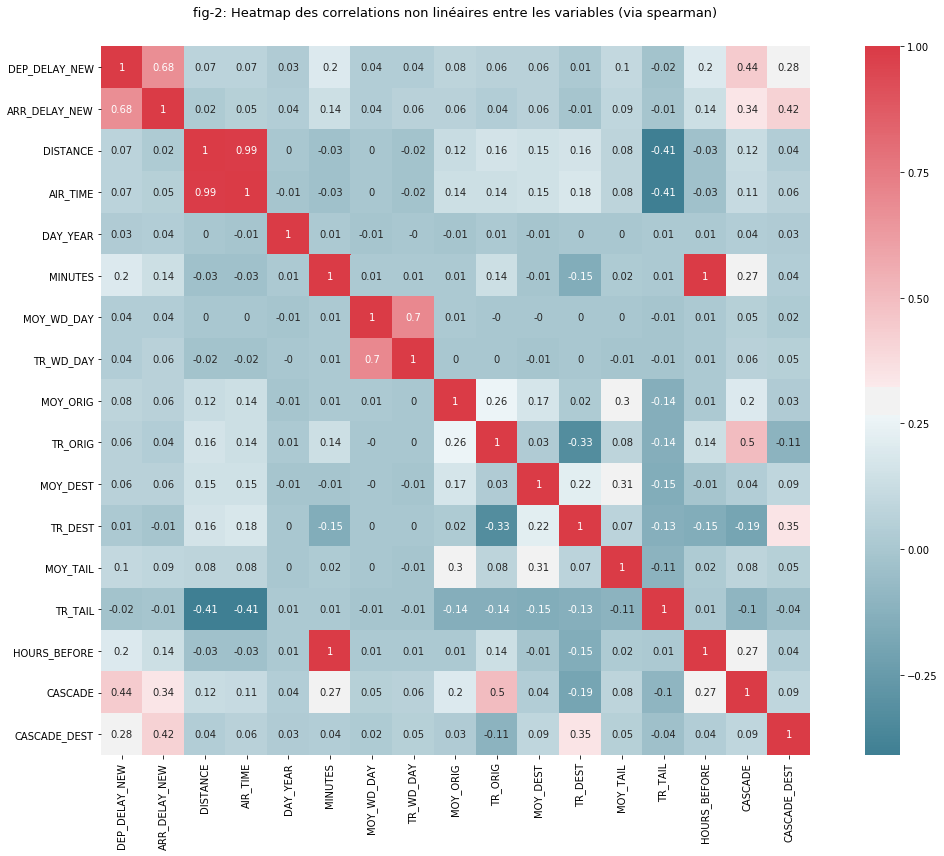

In [13]:
f, ax = plt.subplots(figsize=(16, 12))


corr = data_fly_corr.corr(method='pearson')
corr = np.around(corr,2)
sns.heatmap(corr, annot=True ,mask=np.zeros_like((corr), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('fig-2: Heatmap des correlations linéaires entre les variables (via Pearson)',fontsize=13,loc='center', pad = 30)
plt.tight_layout(h_pad=2)
plt.savefig('pict_correlation1', dpi=400)
plt.show()

f, ax = plt.subplots(figsize=(16, 12))


corr = data_fly_corr.corr(method='spearman')
corr = np.around(corr,2)
sns.heatmap(corr, annot=True ,mask=np.zeros_like((corr), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('fig-2: Heatmap des correlations non linéaires entre les variables (via spearman)',fontsize=13,loc='center', pad = 30)
plt.tight_layout(h_pad=2)
plt.savefig('pict_correlation2', dpi=400)
plt.show()

In [15]:
df = data_fly.copy()

In [16]:
df = data_fly.copy()
df = df.dropna(0, how='any')

In [17]:
# créer une liste qui prend en compte les résultats de nos différents modèles
liste_rmse = []
# noms
liste_name = []

In [18]:
data_fly = df[['DEP_DELAY_NEW','MINUTES','DAY_YEAR','MOY_WD_DAY','MOY_ORIG','MOY_DEST','MOY_TAIL','CASCADE',
              'CASCADE_DEST','ARR_DELAY_NEW']]

In [19]:
# creation des tenseurs numpy 
# creation des vecteurs X et y 
# variables éventuelles 
X = np.matrix(data_fly.iloc[:,:])
# scores éventuels 
y = np.transpose(np.matrix(data_fly.iloc[:,[0,9]]))

#X = np.transpose(X)
y = np.transpose(y)
print (X.shape)
print (y.shape)

(55409, 10)
(55409, 2)


In [20]:
# créer un jeux de test et un jeux d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37124, 10) (18285, 10) (37124, 2) (18285, 2)


In [21]:
# séparer les deux scores
y_train_arr = y_train[:,1]
y_test_arr = y_test[:,1]

y_train = y_train[:,0]
y_test = y_test[:,0]

# En prenant en compte les jours de la semaine

In [22]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,3],y_fit=y_train,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('week_day_linear')

RMSE modèle : 24.35
RMSE naive : 24.36


In [23]:
# régression poly (n=2)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,3],y_fit=y_train,n=2)[:]
liste_rmse.append(rmse_mod)
liste_name.append('week_day_poly2')

RMSE modèle : 24.35
RMSE naive : 24.36


In [24]:
# régression poly (n=3)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,3],y_fit=y_train,n=3)[:]
liste_rmse.append(rmse_mod)
liste_name.append('week_day_poly3')

RMSE modèle : 24.35
RMSE naive : 24.36


In [25]:
# régression poly (n=4)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,3],y_fit=y_train,n=4)[:]
liste_rmse.append(rmse_mod)
liste_name.append('week_day_poly4')

RMSE modèle : 24.35
RMSE naive : 24.36


tester un regression avec régularisation

In [26]:
rmse_mod, rmse_naive = best_model(X_fit=X_train[:,3],y_fit=y_train,n=4,params_min=-6,params_max=-4,nb_params=5)
liste_rmse.append(rmse_mod)
liste_name.append('week_day_poly4reg')

(37124, 5)
{'alpha': array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04])}
-------voici le meilleur paramètre---------
{'alpha': 3.162277660168379e-06}
RMSE du modèle : 24.35
RMSE naive : 24.36


# En prenant en compte les jours de l'année uniquement


In [27]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,2],y_fit=y_train,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('year_day_linear')

RMSE modèle : 24.35
RMSE naive : 24.36


In [28]:
# régression poly (n=2)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,2],y_fit=y_train,n=2)[:]
liste_rmse.append(rmse_mod)
liste_name.append('year_day_poly2')

RMSE modèle : 24.33
RMSE naive : 24.36


In [29]:
# régression poly (n=3)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,2],y_fit=y_train,n=3)[:]
liste_rmse.append(rmse_mod)
liste_name.append('year_day_poly3')

RMSE modèle : 24.33
RMSE naive : 24.36


In [30]:
# régression poly (n=4)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,2],y_fit=y_train,n=4)[:]
liste_rmse.append(rmse_mod)
liste_name.append('year_day_poly4')

RMSE modèle : 24.33
RMSE naive : 24.36


In [31]:
rmse_mod, rmse_naive = best_model(X_fit=X_train[:,2],y_fit=y_train,n=4,params_min=-4,params_max=4,nb_params=5)
liste_rmse.append(rmse_mod)
liste_name.append('year_day_poly4reg')

(37124, 5)
{'alpha': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.01}
RMSE du modèle : 24.32
RMSE naive : 24.36


# Considérer les jours de l'année + les jours de la semaine

In [32]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,2:4],y_fit=y_train,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('tot_day_linear')

RMSE modèle : 24.34
RMSE naive : 24.36


In [33]:
# régression poly (n=2) 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,2:4],y_fit=y_train,n=2)[:]
liste_rmse.append(rmse_mod)
liste_name.append('tot_day_poly2')

RMSE modèle : 24.32
RMSE naive : 24.36


In [34]:
# régression poly (n=3) 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,2:4],y_fit=y_train,n=3)[:]
liste_rmse.append(rmse_mod)
liste_name.append('tot_day_poly3')

RMSE modèle : 24.32
RMSE naive : 24.36


In [35]:
# régression poly (n=4) 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,2:4],y_fit=y_train,n=4)[:]
liste_rmse.append(rmse_mod)
liste_name.append('tot_day_poly4')

RMSE modèle : 24.31
RMSE naive : 24.36


In [36]:
rmse_mod, rmse_naive = best_model(X_fit=X_train[:,2:4],y_fit=y_train,n=4,params_min=-8,params_max=-5,nb_params=5)
liste_rmse.append(rmse_mod)
liste_name.append('tot_day_poly4reg')

(37124, 15)
{'alpha': array([1.00000000e-08, 5.62341325e-08, 3.16227766e-07, 1.77827941e-06,
       1.00000000e-05])}
-------voici le meilleur paramètre---------
{'alpha': 1e-05}
RMSE du modèle : 24.30
RMSE naive : 24.36


# considérer l'heure seule


In [37]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1],y_fit=y_train,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_linear')

RMSE modèle : 24.08
RMSE naive : 24.36


In [38]:
# régression poly (n=2)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1],y_fit=y_train,n=2)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_poly2')

RMSE modèle : 24.08
RMSE naive : 24.36


In [39]:
# régression poly (n=3)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1],y_fit=y_train,n=3)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_poly3')

RMSE modèle : 24.06
RMSE naive : 24.36


In [40]:
# régression poly (n=4)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1],y_fit=y_train,n=4)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_poly4')

RMSE modèle : 24.06
RMSE naive : 24.36


In [41]:
rmse_mod, rmse_naive = best_model(X_fit=X_train[:,1],y_fit=y_train,n=4,params_min=-5,params_max=3,nb_params=5)
liste_rmse.append(rmse_mod)
liste_name.append('hour_poly4reg')

(37124, 5)
{'alpha': array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03])}
-------voici le meilleur paramètre---------
{'alpha': 10.0}
RMSE du modèle : 24.06
RMSE naive : 24.36


# heure et jours de l'année


In [42]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:3],y_fit=y_train,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_year_linear')

RMSE modèle : 24.08
RMSE naive : 24.36


In [43]:
# régression poly(n=2) 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:3],y_fit=y_train,n=2)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_year_poly2')

RMSE modèle : 24.05
RMSE naive : 24.36


In [44]:
# régression poly(n=3) 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:3],y_fit=y_train,n=3)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_year_poly3')

RMSE modèle : 24.02
RMSE naive : 24.36


In [45]:
# régression poly(n=4) 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:3],y_fit=y_train,n=4)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_year_poly4')

RMSE modèle : 24.02
RMSE naive : 24.36


In [46]:
rmse_mod, rmse_naive = best_model(X_fit=X_train[:,1:3],y_fit=y_train,n=4,params_min=-5,params_max=1,nb_params=5)
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_year_poly4reg')

(37124, 15)
{'alpha': array([1.00000000e-05, 3.16227766e-04, 1.00000000e-02, 3.16227766e-01,
       1.00000000e+01])}
-------voici le meilleur paramètre---------
{'alpha': 0.31622776601683794}
RMSE du modèle : 24.00
RMSE naive : 24.36


# heure jours de l'année et jours de la semaine


In [47]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:4],y_fit=y_train,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_linear')

RMSE modèle : 24.07
RMSE naive : 24.36


In [48]:
# régression poly (n=2)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:4],y_fit=y_train,n=2)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_poly2')

RMSE modèle : 24.02
RMSE naive : 24.36


In [49]:
# régression poly (n=3)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:4],y_fit=y_train,n=3)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_poly3')

RMSE modèle : 24.00
RMSE naive : 24.36


In [50]:
# régression poly (n=4)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:4],y_fit=y_train,n=4)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_poly4')

RMSE modèle : 23.99
RMSE naive : 24.36


In [51]:
rmse_mod, rmse_naive = best_model(X_fit=X_train[:,1:4],y_fit=y_train,n=4,params_min=-8,params_max=-4,nb_params=5)
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_poly4reg')

(37124, 35)
{'alpha': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04])}
-------voici le meilleur paramètre---------
{'alpha': 1e-05}
RMSE du modèle : 23.97
RMSE naive : 24.36


# Heure / jours de l'année / jours de la semaine / orig

In [52]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:5],y_fit=y_train,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_origin_linear')

RMSE modèle : 24.01
RMSE naive : 24.36


In [53]:
# régression poly (n=2)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:5],y_fit=y_train,n=2)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_origin_poly2')

RMSE modèle : 23.94
RMSE naive : 24.36


In [54]:
# régression poly (n=3)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:5],y_fit=y_train,n=3)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_origin_poly3')

RMSE modèle : 24.03
RMSE naive : 24.36


In [55]:
# régression poly (n=4)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:5],y_fit=y_train,n=4)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_origin_poly4')

RMSE modèle : 25.05
RMSE naive : 24.36


In [56]:
rmse_mod, rmse_naive = best_model(X_fit=X_train[:,1:5],y_fit=y_train,n=4,params_min=-8,params_max=-5,nb_params=5)
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_origin_poly4reg')

(37124, 70)
{'alpha': array([1.00000000e-08, 5.62341325e-08, 3.16227766e-07, 1.77827941e-06,
       1.00000000e-05])}
-------voici le meilleur paramètre---------
{'alpha': 1e-08}
RMSE du modèle : 23.86
RMSE naive : 24.36


# heure / jours de l'année / jours de la semaine / orig / arriv


In [57]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:6],y_fit=y_train,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_path_linear')

RMSE modèle : 23.96
RMSE naive : 24.36


In [58]:
# régression linéaire (poly n=2)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:6],y_fit=y_train,n=2)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_path_poly2')

RMSE modèle : 23.90
RMSE naive : 24.36


In [59]:
# régression linéaire (poly n=3)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:6],y_fit=y_train,n=3)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_path_poly3')

RMSE modèle : 23.96
RMSE naive : 24.36


In [60]:
# régression linéaire (poly n=4)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:6],y_fit=y_train,n=4)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_path_poly4')

RMSE modèle : 28.13
RMSE naive : 24.36


In [61]:
rmse_mod, rmse_naive = best_model(X_fit=X_train[:,1:6],y_fit=y_train,n=4,params_min=-2,params_max=2,nb_params=5)
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_path__poly4reg')

(37124, 126)
{'alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}
-------voici le meilleur paramètre---------
{'alpha': 100.0}
RMSE du modèle : 23.83
RMSE naive : 24.36


# heure / jours de l'année / jours de la semaine / orig / arriv / appareil


In [62]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:7],y_fit=y_train,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_path_aircraft_linear')

RMSE modèle : 23.92
RMSE naive : 24.36


In [63]:
# régression poly (n=2)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:7],y_fit=y_train,n=2)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_path_aircraft_poly2')

RMSE modèle : 23.85
RMSE naive : 24.36


In [64]:
# régression poly (n=3)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:7],y_fit=y_train,n=3)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_path_aircraft_poly3')

RMSE modèle : 23.92
RMSE naive : 24.36


In [65]:
# régression poly (n=4)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:7],y_fit=y_train,n=4)[:]
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_path_aircraft_poly4')

RMSE modèle : 26.01
RMSE naive : 24.36


In [66]:
rmse_mod, rmse_naive = best_model(X_fit=X_train[:,1:7],y_fit=y_train,n=4,params_min=-1,params_max=4,nb_params=5)
liste_rmse.append(rmse_mod)
liste_name.append('hour_day_tot_path_aircraft_poly4reg')

(37124, 210)
{'alpha': array([1.00000000e-01, 1.77827941e+00, 3.16227766e+01, 5.62341325e+02,
       1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 562.341325190349}
RMSE du modèle : 23.78
RMSE naive : 24.36


# 2) cas où tente de prédir le retard au départ légérement avant 

In [67]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:8],y_fit=y_train,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('before_linear')

RMSE modèle : 21.10
RMSE naive : 24.36


In [68]:
# régression poly (n=2) 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:8],y_fit=y_train,n=2)[:]
liste_rmse.append(rmse_mod)
liste_name.append('before_poly2')

RMSE modèle : 20.65
RMSE naive : 24.36


In [69]:
# régression poly (n=3) 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:8],y_fit=y_train,n=3)[:]
liste_rmse.append(rmse_mod)
liste_name.append('before_poly3')

RMSE modèle : 20.84
RMSE naive : 24.36


In [70]:
# régression poly (n=4) 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:8],y_fit=y_train,n=4)[:]
liste_rmse.append(rmse_mod)
liste_name.append('before_poly4')

RMSE modèle : 32.44
RMSE naive : 24.36


In [71]:
rmse_mod, rmse_naive = best_model(X_fit=X_train[:,1:8],y_fit=y_train,n=4,params_min=1,params_max=4,nb_params=5)
liste_rmse.append(rmse_mod)
liste_name.append('before_poly4reg')

(37124, 330)
{'alpha': array([   10.        ,    56.23413252,   316.22776602,  1778.27941004,
       10000.        ])}
-------voici le meilleur paramètre---------
{'alpha': 1778.2794100389228}
RMSE du modèle : 20.50
RMSE naive : 24.36


#  3 ) Retard anticipé à l'arrivé lorsque l'on connait l'heure de départ

In [72]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:8],y_fit=y_train_arr,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('arrival_linear_naiv')

RMSE modèle : 21.39
RMSE naive : 24.43


In [73]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,1:9],y_fit=y_train_arr,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('arrival_linear_airport')

RMSE modèle : 18.69
RMSE naive : 24.43


In [74]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,0],y_fit=y_train_arr,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('arrival_depknow_linear')

RMSE modèle : 8.85
RMSE naive : 24.43


In [75]:
# régression linéaire 
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,[0,1,2,3,4,5,6,8]],y_fit=y_train_arr,n=1)[:]
liste_rmse.append(rmse_mod)
liste_name.append('arrival_all_linear')

RMSE modèle : 8.57
RMSE naive : 24.43


In [76]:
# régression poly(n=2)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,[0,1,2,3,4,5,6,8]],y_fit=y_train_arr,n=2)[:]
liste_rmse.append(rmse_mod)
liste_name.append('arrival_all_poly2')

RMSE modèle : 8.41
RMSE naive : 24.43


In [77]:
# régression poly(n=3)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,[0,1,2,3,4,5,6,8]],y_fit=y_train_arr,n=3)[:]
liste_rmse.append(rmse_mod)
liste_name.append('arrival_all_poly3')

RMSE modèle : 8.39
RMSE naive : 24.43


In [78]:
# régression poly(n=4)
rmse_mod, rmse_naive = analyse(X_fit=X_train[:,[0,1,2,3,4,5,6,8]],y_fit=y_train_arr,n=4)[:]
liste_rmse.append(rmse_mod)
liste_name.append('arrival_all_poly4')

RMSE modèle : 14.26
RMSE naive : 24.43


In [79]:
# régression poly(n=4) + regularisation
rmse_mod, rmse_naive = best_model(X_fit=X_train[:,[0,1,2,3,4,5,6,8]],y_fit=y_train_arr,n=4,params_min=3,params_max=5,nb_params=5)
liste_rmse.append(rmse_mod)
liste_name.append('arrival_poly4reg')

(37124, 495)
{'alpha': array([  1000.        ,   3162.27766017,  10000.        ,  31622.77660168,
       100000.        ])}
-------voici le meilleur paramètre---------
{'alpha': 1000.0}
RMSE du modèle : 8.24
RMSE naive : 24.43


# Performance des modèles finaux sur le test set 

In [80]:
# performance sur le modèle final dans le cas où on cherche à prédire de retard au départ longtemps à l'avance 
X_fit = X_train[:,1:7]
X_fit_t = X_test[:,1:7]

y_train = y_train
y_test = y_test

alpha = 31
rmse_mod, rmse_naive,y_predict_lr = perform(X_train=X_fit,X_test=X_fit_t,y_train=y_train,y_test=y_test,alpha=alpha,n=4)

(18285, 210)
RMSE du modèle : 23.67
RMSE naive : 24.18


<function matplotlib.pyplot.show(*args, **kw)>

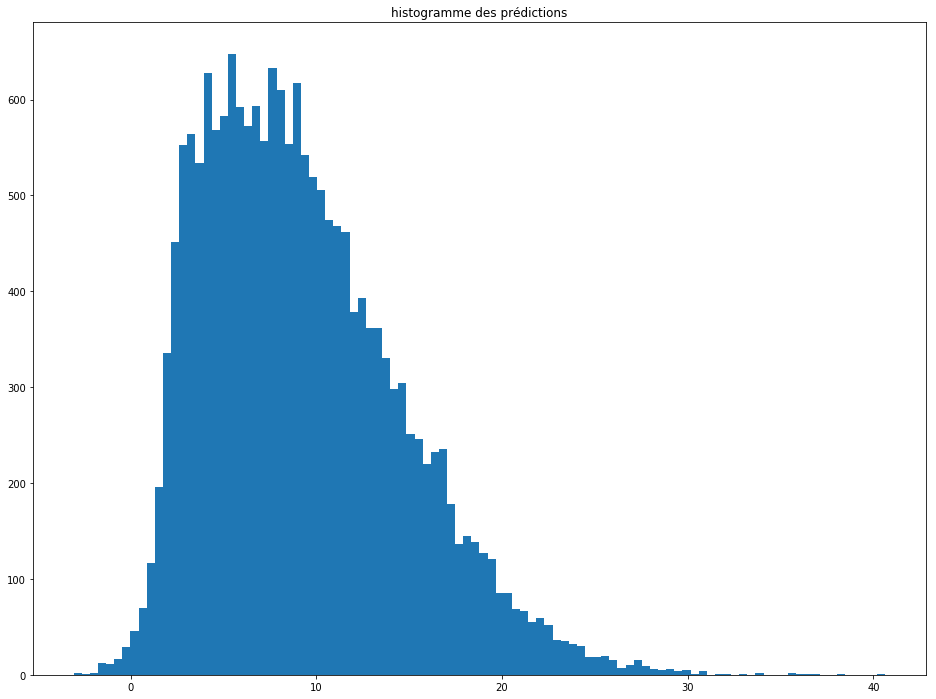

In [81]:
# on regarde l'histogramme des prédictions
fig = plt.figure(figsize=(16, 12))
plt.hist(y_predict_lr, bins=100)
plt.title('histogramme des prédictions')

plt.show

In [82]:
# on note les différent percentiles (utile dans l'API pour afficher les résultats en nuances de couleur)
print(np.percentile(y_predict_lr[:], 50))
print(np.percentile(y_predict_lr[:], 33.333))
print(np.percentile(y_predict_lr[:], 16.666))
print(np.percentile(y_predict_lr[:], 66.666))
print(np.percentile(y_predict_lr[:], 83.666))


8.480173632374022
6.200057780797513
4.011978009110986
10.971602945267406
14.561355174645914


In [83]:
# performance sur le modèle final dans le cas où on cherche à prédire le retard au départ quelques heures à l'avance
X_fit = X_train[:,1:8]
X_fit_t = X_test[:,1:8]

y_train = y_train
y_test = y_test

alpha = 316
rmse_mod, rmse_naive, y_predict_lr = perform(X_train=X_fit,X_test=X_fit_t,y_train=y_train,y_test=y_test,alpha=alpha,n=4)

(18285, 330)
RMSE du modèle : 20.94
RMSE naive : 24.18


In [84]:
# étudier l'impact du nombre d'exemples sur la rmse
data_fly2 = df[['DEP_DELAY_NEW','MINUTES','DAY_YEAR','MOY_WD_DAY','MOY_ORIG','MOY_DEST','MOY_TAIL','CASCADE',
              'CASCADE_DEST','ARR_DELAY_NEW']]

n=10000
data_fly2 = shuffle(data_fly2) 
 # creation des tenseurs numpy 
    # creation des vecteurs X et y 
    # variables éventuelles 
X = np.matrix(data_fly2.iloc[:,:])
    # scores éventuels 
y2 = np.transpose(np.matrix(data_fly2.iloc[:,0]))

    #X = np.transpose(X)
#y = np.transpose(y)
print (X.shape)
print (y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.33, random_state=42)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

err_t = []
for i in range (0,n,200):
    # mélanger les données   
    
    # performance sur le modèle final dans le cas où on cherche à prédire le retard au départ quelques heures à l'avance
    X_fit = X_train[0:int(np.around(i*(data_fly2.shape[0])/n))-1,1:8]
    X_fit_t = X_test[:,1:8]

    y_train2 = y_train[0:int(np.around(i*(data_fly2.shape[0])/n))-1,:]
    y_test2 = y_test[:,:]

    alpha = 316
    rmse_mod, rmse_naive, y_predict_lr = perform(X_train=X_fit,X_test=X_fit_t,y_train=y_train2,y_test=y_test2,alpha=alpha,n=4)
    err_t.append(rmse_mod)
    print (i)
    



(55409, 10)
(55409, 2)
(37124, 10) (18285, 10) (37124, 1) (18285, 1)
(18285, 330)
RMSE du modèle : 20.63
RMSE naive : 24.28
0
(18285, 330)
RMSE du modèle : 21.10
RMSE naive : 24.29
200
(18285, 330)
RMSE du modèle : 21.24
RMSE naive : 24.29
400
(18285, 330)
RMSE du modèle : 20.88
RMSE naive : 24.29
600
(18285, 330)
RMSE du modèle : 20.99
RMSE naive : 24.29
800
(18285, 330)
RMSE du modèle : 21.18
RMSE naive : 24.28
1000
(18285, 330)
RMSE du modèle : 20.77
RMSE naive : 24.28
1200
(18285, 330)
RMSE du modèle : 20.69
RMSE naive : 24.28
1400
(18285, 330)
RMSE du modèle : 20.69
RMSE naive : 24.28
1600
(18285, 330)
RMSE du modèle : 20.71
RMSE naive : 24.28
1800
(18285, 330)
RMSE du modèle : 20.74
RMSE naive : 24.28
2000
(18285, 330)
RMSE du modèle : 20.71
RMSE naive : 24.28
2200
(18285, 330)
RMSE du modèle : 20.68
RMSE naive : 24.28
2400
(18285, 330)
RMSE du modèle : 20.69
RMSE naive : 24.28
2600
(18285, 330)
RMSE du modèle : 20.70
RMSE naive : 24.28
2800
(18285, 330)
RMSE du modèle : 20.71
RM

In [85]:
print (len(err_t))

50


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[20.626549322459603, 21.101706860555826, 21.24463844120019, 20.880553510986218, 20.99071929833136, 21.183613624137596, 20.76557895801465, 20.687225812275003, 20.688174941479918, 20.709449090165606, 20.737690172789097, 20.711273677700724, 20.680398869200378, 20.69467763666412, 20.704402598743624, 20.70727200101423, 20.717202580335357, 20.718698116889204, 20.724208406437338, 20.712430502328107, 20.683647726048342, 20.66552590873715, 20.663162453640442, 20.654354079020266, 20.660228784191187, 20.65372606044629, 20.65407781193385, 20.641492345077765, 20.634301567785286, 20.633488365520762, 20.62694241263864, 20.625954297710944, 20.619743342005215, 20.627729108203653, 20.62652914511602, 20.62652914511602, 20.62652914511602, 20.62652914511602, 20.62652914511602, 20.62652914511602, 20.62652914511602, 20.6

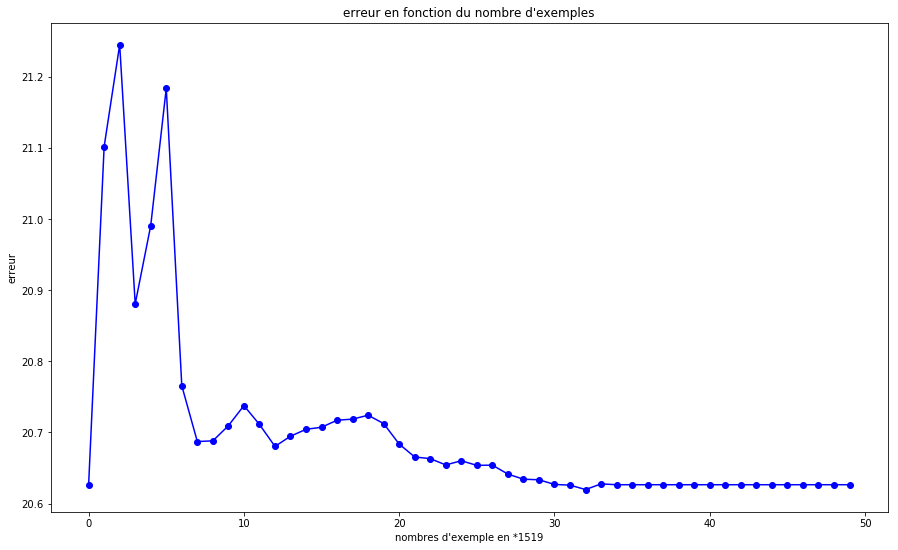

In [86]:

# regarder si plus de données nous apportent de l'information
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

plt.title("erreur en fonction du nombre d'exemples")
plt.xlabel("nombres d'exemple en *1519")
plt.ylabel('erreur')

indice = []
n=50
for i in range (n):
    
    indice.append(i)
print (indice)
print (err_t)
plt.plot(indice[:], err_t[:], linestyle='-', c='blue') 

plt.plot(indice[:], err_t[:], 'ro', markersize=6, c='blue')

#plt.plot(X_droite[:,1], y_droite, linestyle='--', c='red')
#plt.plot(X[:,1], y_predict, linestyle='-', c='blue')
#plt.axis([2, 50, np.amin(err_t[:]),23.225])
plt.savefig('pict_err.png', dpi=400)



plt.show()

In [87]:
# on note les différent percentiles (utile dans l'API pour afficher les résultats en nuances de couleur)
print(np.percentile(y_predict_lr[:], 50))
print(np.percentile(y_predict_lr[:], 33.333))
print(np.percentile(y_predict_lr[:], 16.666))
print(np.percentile(y_predict_lr[:], 66.666))
print(np.percentile(y_predict_lr[:], 83.666))

4.409418630831892
2.838578706721668
1.8625761957891105
7.777664757502144
15.578428306271597


In [88]:
# performance sur le modèle final dans le cas où on cherche à prédire le retard au départ quelques heures à l'avance
X_fit = X_train[:,[0,1,2,3,4,5,6,8]]
X_fit_t = X_test[:,[0,1,2,3,4,5,6,8]]

y_train = y_train_arr
y_test = y_test_arr

alpha = 1000
rmse_mod, rmse_naive, y_predict_lr = perform(X_train=X_fit,X_test=X_fit_t,y_train=y_train,y_test=y_test,alpha=alpha,n=4)

(18285, 495)
RMSE du modèle : 24.32
RMSE naive : 24.29


In [89]:
# on note les différent percentiles (utile dans l'API pour afficher les résultats en nuances de couleur)
print(np.percentile(y_predict_lr[:], 50))
print(np.percentile(y_predict_lr[:], 33.333))
print(np.percentile(y_predict_lr[:], 16.666))
print(np.percentile(y_predict_lr[:], 66.666))
print(np.percentile(y_predict_lr[:], 83.666))

9.275199021673597
9.10641516882773
8.789484597271024
9.43320244831112
9.699124624655044


<function matplotlib.pyplot.show(*args, **kw)>

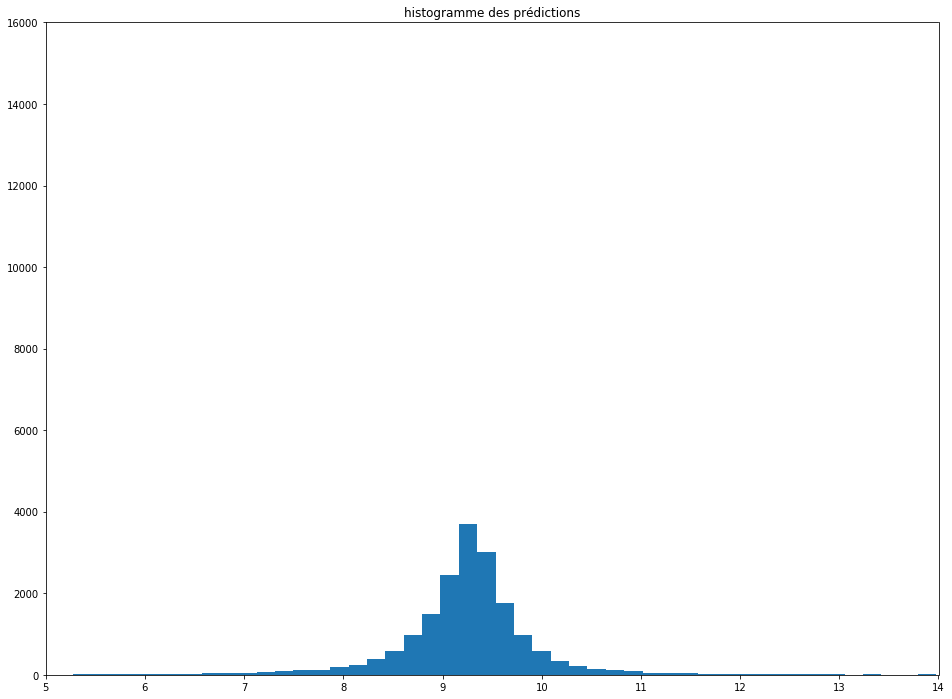

In [90]:
# on regarde l'histogramme des prédictions
fig = plt.figure(figsize=(16, 12))
plt.hist(y_predict_lr, bins=300)
plt.axis([5, 14, 0,16000])
plt.title('histogramme des prédictions')
plt.savefig('pict_hist_pred.png', dpi=400)

plt.show

# Enregistrement des modèles utilisés dans l'API 

In [91]:
from sklearn.externals import joblib

On va entrainer les modèles finaux sur l'ensemble du dataset

In [92]:
# sauvegarde du modèle final dans le cas où on cherche à prédire de retard au départ longtemps à l'avance 
X_fit = X[:,1:7]
y_fit = y[:,0]
print (X.shape)
print (y.shape)
alpha = 31
# ajouter des features polynomiales couplées 
poly = PolynomialFeatures(4)
X_fit = poly.fit_transform(X_fit)
y_fit = y_fit
    
# on va standardiser les données de telle sorte à ce que 
std_scale = preprocessing.StandardScaler().fit(X_fit)
# on enregistre le scaler
joblib.dump(std_scale, 'model_big_scaler.joblib') 
X_fit = std_scale.transform(X_fit)
    
# On crée un modèle de régression linéaire
model_big = linear_model.Ridge(alpha=alpha) 

# entrainer le modèle
model_big.fit(X_fit,y_fit)
    
# save
joblib.dump(model_big, 'model_big.joblib') 

(55409, 10)
(55409, 2)


['model_big.joblib']

In [93]:
# sauvegarde du modèle final dans le cas où on cherche à prédire de retard au départ quelques heures à l'avance 
X_fit = X[:,1:8]
y_fit = y[:,0]

alpha = 316
# ajouter des features polynomiales couplées 
poly = PolynomialFeatures(4)
X_fit = poly.fit_transform(X_fit)
y_fit = y_fit
    
# on va standardiser les données de telle sorte à ce que 
std_scale = preprocessing.StandardScaler().fit(X_fit)
# on enregistre le scaler
joblib.dump(std_scale, 'model_medium_scaler.joblib') 
X_fit = std_scale.transform(X_fit)
    
# On crée un modèle de régression linéaire
model_medium = linear_model.Ridge(alpha=alpha) 

# entrainer le modèle
model_medium.fit(X_fit,y_fit)

# save
joblib.dump(model_medium, 'model_medium.joblib') 

['model_medium.joblib']

In [94]:
# sauvegarde du modèle final dans le cas où on cherche à prédire de retard au départ quelques heures à l'avance 


X_fit = X[:,[0,1,2,3,4,5,6,8]]
y_fit = y[:,1]

alpha = 1000
# ajouter des features polynomiales couplées 
poly = PolynomialFeatures(4)
X_fit = poly.fit_transform(X_fit)
y_fit = y_fit
    
# on va standardiser les données de telle sorte à ce que 
std_scale = preprocessing.StandardScaler().fit(X_fit)
# on enregistre le scaler
joblib.dump(std_scale, 'model_small_scaler.joblib') 
X_fit = std_scale.transform(X_fit)
    
# On crée un modèle de régression linéaire
model_small = linear_model.Ridge(alpha=alpha) 

# entrainer le modèle
model_small.fit(X_fit,y_fit)

# save 
joblib.dump(model_small, 'model_small.joblib') 

['model_small.joblib']

No handles with labels found to put in legend.
C:\Users\tanne\Anaconda3\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "modele". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


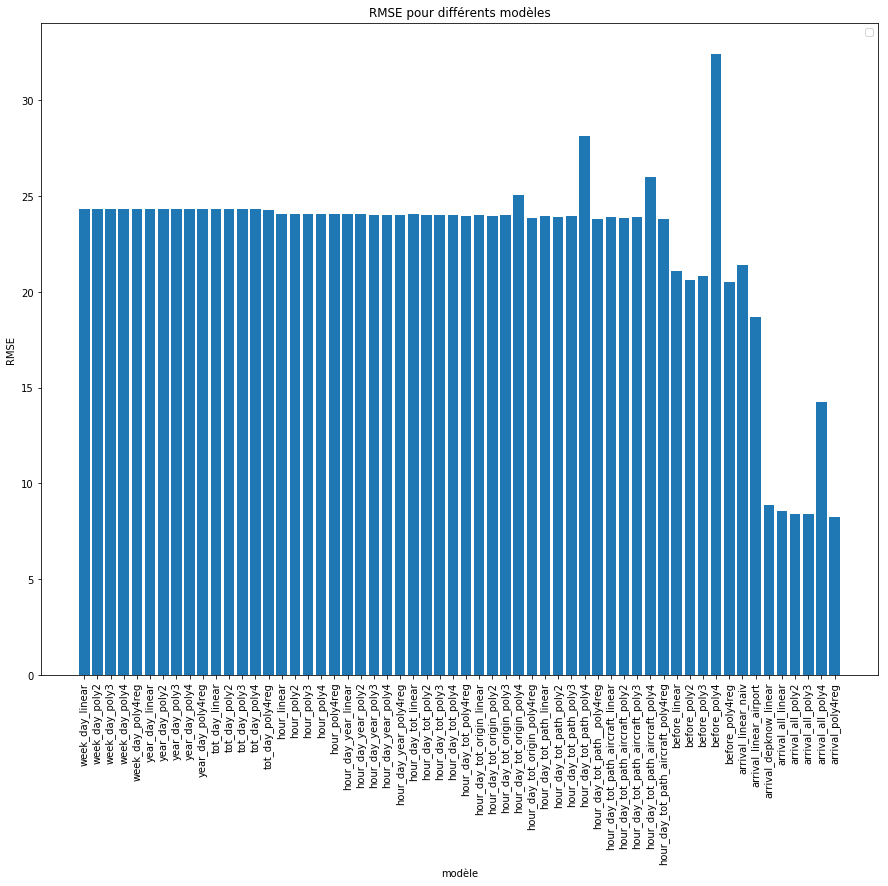

In [95]:
plt.figure(figsize=(15,12))
plt.title('RMSE pour différents modèles')
plt.bar(liste_name[:],liste_rmse[:])
plt.legend(loc = 'modele')
        
plt.axis('tight')
plt.ylabel('RMSE ')
plt.xlabel('modèle')

plt.xticks(rotation=90)
plt.savefig('pict_rmsepred.png', dpi=400)
plt.show()  